# Building a Regression Model for a Financial Dataset

In this notebook, you will build a simple linear regression model to predict the closing AAPL stock price. The lab objectives are:
* Pull data from BigQuery into a Pandas dataframe
* Use Matplotlib to visualize data
* Use Scikit-Learn to build a regression model

In [69]:
# !sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [70]:
# !pip install google-cloud-bigquery==1.25.0

**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

In [71]:
# %%bash

# bq mk -d ai4f
# bq load --autodetect --source_format=CSV ai4f.AAPL10Y ../data/AAPL10Y.csv

Since I do not have a Google Cloud Services account, I switched to Pandas and sqlite3 to achieve the same task as above:

In [72]:
import pandas as pd
import sqlite3

# Define the table name and filepath
table_name = "AAPL10Y"
csv_file_path = f"../data/{table_name}.csv"
db_file_path = f"{table_name}.db"

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(csv_file_path)

# Create a SQLite database and store the DataFrame as a table
with sqlite3.connect(db_file_path) as conn:
    data.to_sql(table_name, conn, if_exists='replace', index=False)

print("Data loaded into SQLite database successfully.")

Data loaded into SQLite database successfully.


In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rc('figure', figsize=(12, 8.0))

## Pull Data from BigQuery

In this section we'll use a magic function to query a BigQuery table and then store the output in a Pandas dataframe. A magic function is just an alias to perform a system command. To see documentation on the "bigquery" magic function execute the following cell:

The query below selects everything you'll need to build a regression model to predict the closing price of AAPL stock. The model will be very simple for the purposes of demonstrating BQML functionality. The only features you'll use as input into the model are the previous day's closing price and a three day trend value. The trend value can only take on two values, either -1 or +1. If the AAPL stock price has increased over any two of the previous three days then the trend will be +1. Otherwise, the trend value will be -1.

Note, the features you'll need can be generated from the raw table `ai4f.AAPL10Y` using Pandas functions. However, it's better to take advantage of the serverless-ness of BigQuery to do the data pre-processing rather than applying the necessary transformations locally.  

In [74]:
# %%bigquery df
# WITH
#   raw AS (
#   SELECT
#     date,
#     close,
#     LAG(close, 1) OVER(ORDER BY date) AS min_1_close,
#     LAG(close, 2) OVER(ORDER BY date) AS min_2_close,
#     LAG(close, 3) OVER(ORDER BY date) AS min_3_close,
#     LAG(close, 4) OVER(ORDER BY date) AS min_4_close
#   FROM
#     `ai4f.AAPL10Y`
#   ORDER BY
#     date DESC ),
#   raw_plus_trend AS (
#   SELECT
#     date,
#     close,
#     min_1_close,
#     IF (min_1_close - min_2_close > 0, 1, -1) AS min_1_trend,
#     IF (min_2_close - min_3_close > 0, 1, -1) AS min_2_trend,
#     IF (min_3_close - min_4_close > 0, 1, -1) AS min_3_trend
#   FROM
#     raw ),
#   train_data AS (
#   SELECT
#     date,
#     close,
#     min_1_close AS day_prev_close,
#     IF (min_1_trend + min_2_trend + min_3_trend > 0, 1, -1) AS trend_3_day
#   FROM
#     raw_plus_trend
#   ORDER BY
#     date ASC )
# SELECT
#   *
# FROM
#   train_data

#### Case 1 pre-processing: 
Switching to Pandas to achieve the same task as above:

In [75]:
N = 3 # to find N-day trend

# Example DataFrame loading
train_data = pd.read_csv(csv_file_path)
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.sort_values('date', inplace=True)  # Ensure data is sorted by date

# Generate shifted columns dynamically
for i in range(1, N + 2):
    train_data[f'min_{i}_close'] = train_data['close'].shift(i)

# Calculate trend dynamically
for i in range(1, N + 1):
    train_data[f'min_{i}_trend'] = (train_data[f'min_{i}_close'] - train_data[f'min_{i+1}_close']).apply(lambda x: 1 if x > 0 else -1)

# Sum trends to calculate overall N-day trend
train_data['trend_N_day'] = train_data[[f'min_{i}_trend' for i in range(1, N+1)]].sum(axis=1).apply(lambda x: 1 if x > 0 else -1)

# Prepare final DataFrame
final_columns = ['date', 'close', 'min_1_close', 'trend_N_day']
df = train_data[final_columns].rename(columns={'min_1_close': 'day_prev_close'})
df = df.sort_values('date')
df

,date,close,day_prev_close,trend_N_day
2516,2009-06-03,20.1357,NaN,-1
2515,2009-06-04,20.5343,20.1357,-1
2514,2009-06-05,20.6671,20.5343,-1
2513,2009-06-08,20.5500,20.6671,1
2512,2009-06-09,20.3886,20.5500,1
...,...,...,...,...
4,2019-05-28,178.2300,178.9700,-1
3,2019-05-29,177.3800,178.2300,-1
2,2019-05-30,178.3000,177.3800,-1
1,2019-05-31,175.0700,178.3000,-1


#### Case 2 pre-processing: 
Switching to sqlite3 to achieve the same task as above:

In [76]:
# Generate the SQL parts for the lag columns and trend calculations
lag_columns = ", ".join(f"LAG(close, {i}) OVER (ORDER BY date) AS min_{i}_close" for i in range(1, N + 2))
trend_cases = ", ".join(f"CASE WHEN min_{i}_close - min_{i+1}_close > 0 THEN 1 ELSE -1 END AS min_{i}_trend" 
                        for i in range(1, N + 1))

# Full SQL query
sql_query = f"""
WITH Lagged_Data AS (
    SELECT date, close, {lag_columns}
    FROM {table_name}
    ORDER BY date DESC 
),
Trend_Data AS (
    SELECT date, close, min_1_close, {trend_cases}
    FROM Lagged_Data
)
SELECT date, close, min_1_close AS day_prev_close,
    CASE WHEN ({' + '.join(f'min_{i}_trend' for i in range(1, N + 1))}) > 0 THEN 1 ELSE -1 END AS trend_N_day
FROM Trend_Data
ORDER BY date ASC;
"""
 
# Connect and Execute the SQL query
with sqlite3.connect(db_file_path) as conn:
    df = pd.read_sql_query(sql_query, conn)

# Display the results
df = df.sort_values('date')
df

,date,close,day_prev_close,trend_N_day
0,2009/06/03,20.1357,NaN,-1
1,2009/06/04,20.5343,20.1357,-1
2,2009/06/05,20.6671,20.5343,-1
3,2009/06/08,20.5500,20.6671,1
4,2009/06/09,20.3886,20.5500,1
...,...,...,...,...
2512,2019/05/28,178.2300,178.9700,-1
2513,2019/05/29,177.3800,178.2300,-1
2514,2019/05/30,178.3000,177.3800,-1
2515,2019/05/31,175.0700,178.3000,-1


View the first five rows of the query's output. Note that the object `df` containing the query output is a Pandas Dataframe.

In [77]:
print(type(df))
df.dropna(inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,close,day_prev_close,trend_N_day
1,2009/06/04,20.5343,20.1357,-1
2,2009/06/05,20.6671,20.5343,-1
3,2009/06/08,20.5500,20.6671,1
4,2009/06/09,20.3886,20.5500,1
5,2009/06/10,20.0357,20.3886,-1


## Visualize data

The simplest plot you can make is to show the closing stock price as a time series. Pandas DataFrames have built in plotting funtionality based on Matplotlib. 

<Axes: xlabel='date'>

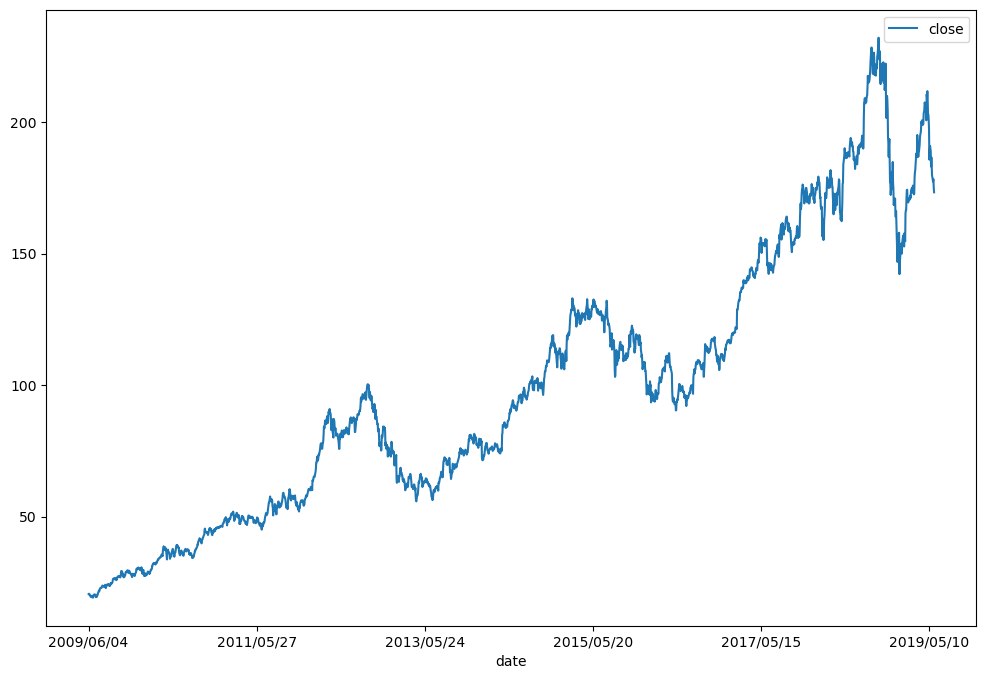

In [78]:
df.plot(x='date', y='close')

You can also embed the `trend_N_day` variable into the time series above. 

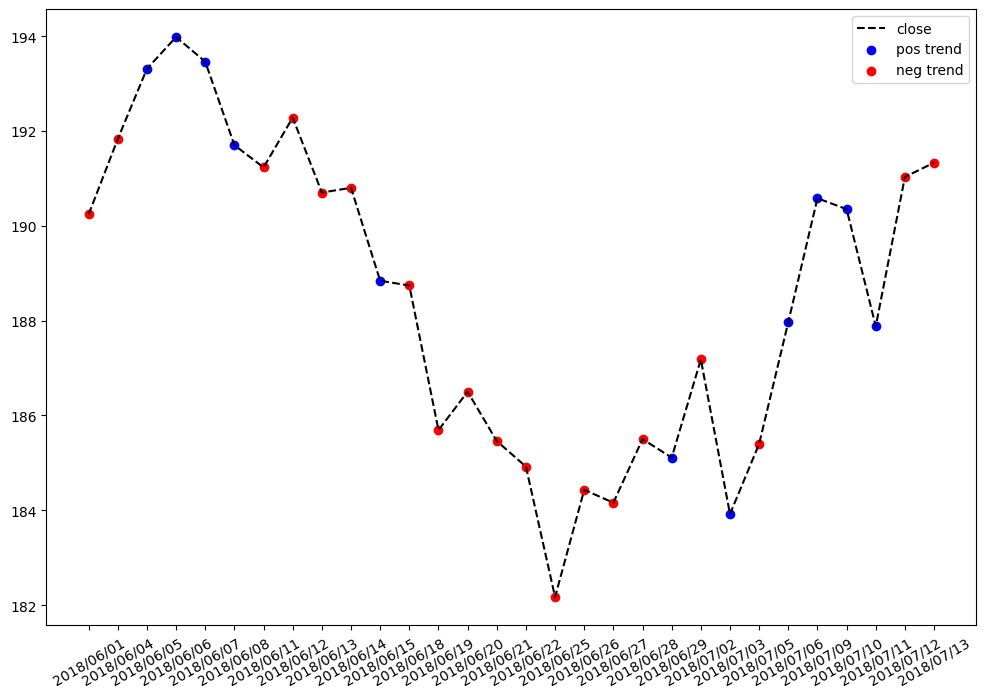

In [79]:
start_date = '2018-06-01'
end_date = '2018-07-15'

plt.plot(
    'date', 'close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_N_day == 1 & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_N_day == -1) & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 30)
plt.show()

In [80]:
df.shape

(2516, 4)

## Build a Regression Model in Scikit-Learn

In this section you'll train a linear regression model to predict AAPL closing prices when given the previous day's closing price `day_prev_close` and the three day trend `trend_N_day`. A training set and test set are created by sequentially splitting the data after 2000 rows. 

In [81]:
features = ['day_prev_close', 'trend_N_day']
target = 'close'
train_row = 2000

X_train, X_test = df.loc[:train_row, features], df.loc[train_row:, features]
y_train, y_test = df.loc[:train_row, target], df.loc[train_row:, target]

In [82]:
# Create linear regression object. Don't include an intercept,
regr = linear_model.LinearRegression(fit_intercept=False)

In [83]:
# Train the model using the training set
regr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [84]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [85]:
# Print the root mean squared error of your predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Print the variance score (1 is perfect prediction)
print(f"Variance score: {r2_score(y_test, y_pred):.2f}")

Root Mean Squared Error: 2.99
Variance score: 0.98


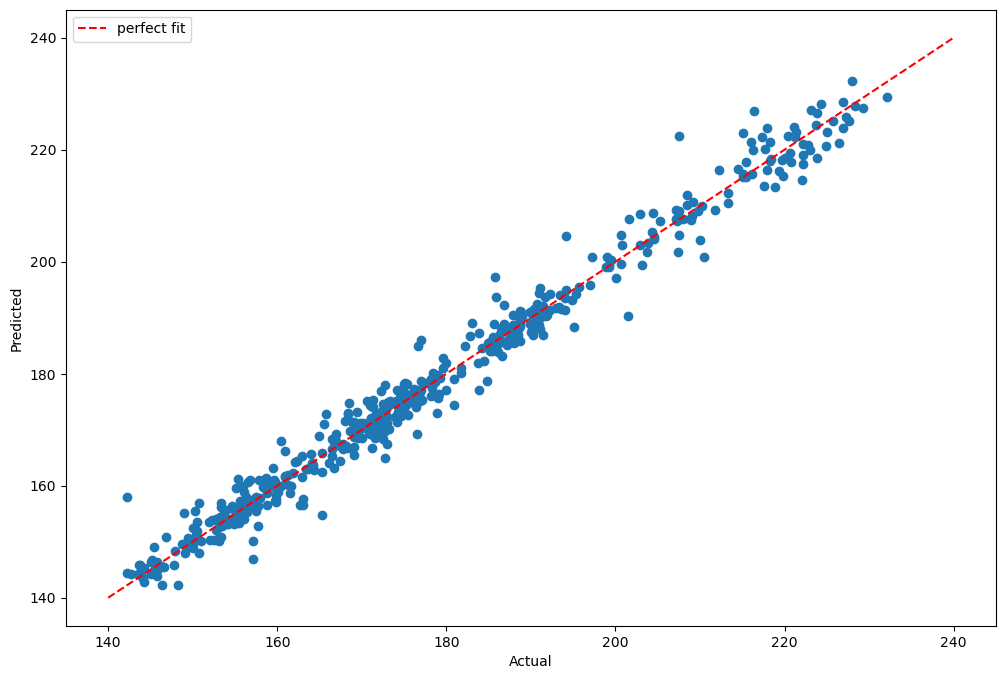

In [86]:
# Plot the predicted values against their corresponding true values
plt.scatter(y_test, y_pred)
plt.plot([140, 240], [140, 240], 'r--', label='perfect fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

The model's predictions are more or less in line with the truth. However, the utility of the model depends on the business context (i.e. you won't be making any money with this model). It's fair to question whether the variable `trend_N_day` even adds to the performance of the model:

In [87]:
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, X_test.day_prev_close))))

Root Mean Squared Error: 2.98


<!-- Indeed, the RMSE is actually lower if we simply use the previous day's closing value as a prediction! Does increasing the number of days included in the trend improve the model? Feel free to create new features and attempt to improve model performance! -->

Somehow, the RMSE did not change compared to previous evaluation. Also, variance equal to 1 points towards overfitting. #TODO Need to check this in the future